In [1]:
import torch, torchvision
print(torch.__version__, torchvision.__version__)

2.5.1+cu121 0.20.1+cu121


In [6]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qr6lcack
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qr6lcack
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.2 MB/s eta 0:00:00:00:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6361712 sha256=a88b33364bc41c64757df27f05335881444aa51b549283ffd5e8c3ba5106fcbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-8r0pctiz/wheels/47/e5/15/94c80df2ba8

In [46]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog, DatasetCatalog
from PIL import Image
import os
import json
import numpy as np
import shutil
import random
import cv2
from detectron2.utils.visualizer import Visualizer


In [4]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15771 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 28.38 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.


In [26]:
annotations_file = "/kaggle/input/building-instance-annotation/corrected_annotation.json"

dataset_path = "/kaggle/input/synthetic-word-ocr/train/images"

In [17]:
output_dir = "/kaggle/working/output"

In [13]:
with open(annotations_file, "r") as f:
    building_data = json.load(f)

In [14]:
building_data.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [18]:
image_ids = [img["id"] for img in building_data["images"]]
random.shuffle(image_ids)

In [19]:

# Split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8  

# Split image IDs into train and test sets
split_idx = int(len(image_ids) * split_ratio)
train_ids = set(image_ids[:split_idx])
test_ids = set(image_ids[split_idx:])

In [20]:
# Separate images and annotations
def filter_coco_data(image_ids, data):
    """Filter images and annotations based on image IDs."""
    images = [img for img in data["images"] if img["id"] in image_ids]
    annotations = [ann for ann in data["annotations"] if ann["image_id"] in image_ids]
    return {"info": data["info"], "categories": data["categories"], "images": images, "annotations": annotations}


In [24]:
train_building = filter_coco_data(train_ids, building_data)
test_building = filter_coco_data(test_ids, building_data)

In [25]:
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "train.json"), "w") as f:
    json.dump(train_building, f, indent=4)
with open(os.path.join(output_dir, "test.json"), "w") as f:
    json.dump(test_building, f, indent=4)

In [37]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("building_train", {}, "/kaggle/working/output/train.json", "/kaggle/input/synthetic-word-ocr/train/images")
register_coco_instances("building_val", {}, "/kaggle/working/output/test.json", "/kaggle/input/synthetic-word-ocr/train/images")

In [38]:
building_metadata = MetadataCatalog.get("building_train")

In [42]:
train_building = DatasetCatalog.get("building_train")  # This should return a list

In [89]:
test_building_metadata = MetadataCatalog.get("building_val")
test_building = DatasetCatalog.get("building_val")

In [51]:
import matplotlib.pyplot as plt

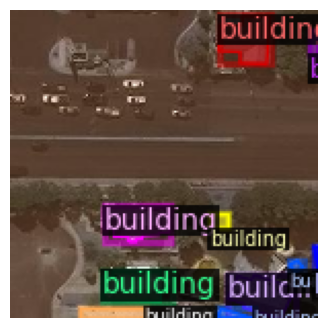

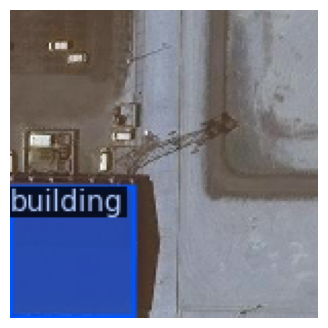

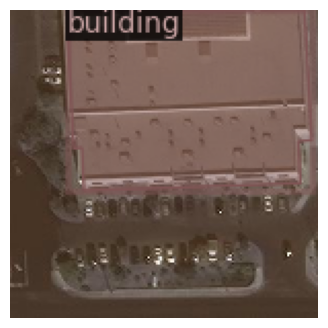

In [53]:
for d in random.sample(train_building, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=building_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(4,4))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")  # Hide axes
    plt.show()

In [56]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [60]:
from detectron2.model_zoo import get_config_file, get_checkpoint_url

In [67]:
from detectron2.engine import DefaultPredictor

In [71]:
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("building_train",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
# cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "weights/resnext101"
cfg.INPUT.MASK_FORMAT = 'bitmask'

In [72]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [74]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/weights/resnext101/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [ ]:
class CustomVisualizer(Visualizer):
    def from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
import cv2
import random

# Custom Visualizer to remove text labels
class CustomVisualizer(Visualizer):
    def _create_text_labels(self, classes, scores, class_names, is_crowd=None):
        return None  # Prevent text from being drawn

for d in random.sample(train_building, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # Get model predictions
    
    # Visualize the input image with ground truth annotations
    v_input = CustomVisualizer(im[:, :, ::-1], metadata=building_metadata, scale=0.5)
    input_image = v_input.draw_dataset_dict(d)  # Ground truth annotations

    # Visualize the predicted output (without labels)
    v_output = CustomVisualizer(im[:, :, ::-1], metadata=building_metadata, scale=0.5)
    instances = outputs["instances"].to("cpu")
    out = v_output.draw_instance_predictions(instances)  # Predictions without labels
    
    # Display both images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    ax[0].imshow(input_image.get_image()[:, :, ::-1])
    ax[0].axis("off")  # Hide axis
    ax[0].set_title("Input (Ground Truth Annotations)")

    ax[1].imshow(out.get_image()[:, :, ::-1])
    ax[1].axis("off")
    ax[1].set_title("Output (Predictions Without Labels)")

    plt.show()
(self, classes, scores, class_names, is_crowd=None):
        return None 

/kaggle/input/synthetic-word-ocr/train/images/000000158403.jpg


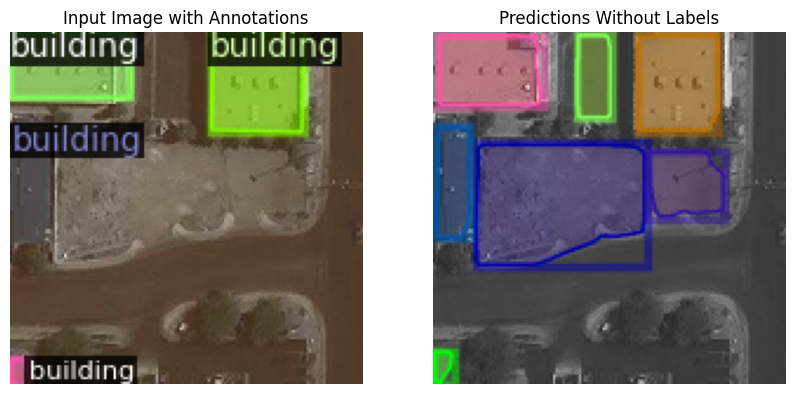

/kaggle/input/synthetic-word-ocr/train/images/000000000764.jpg


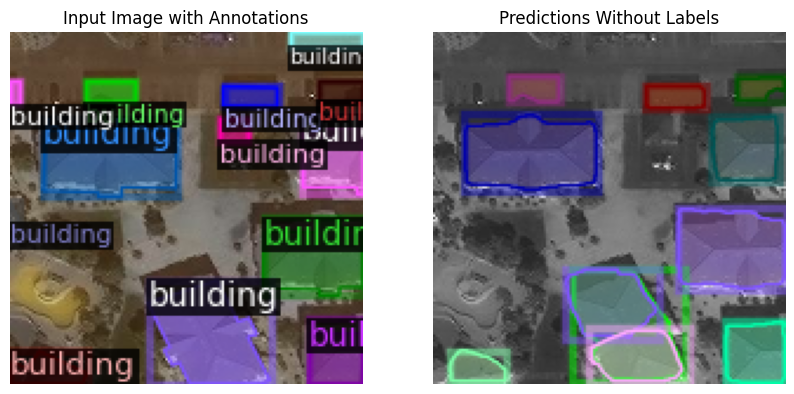

/kaggle/input/synthetic-word-ocr/train/images/000000155630.jpg


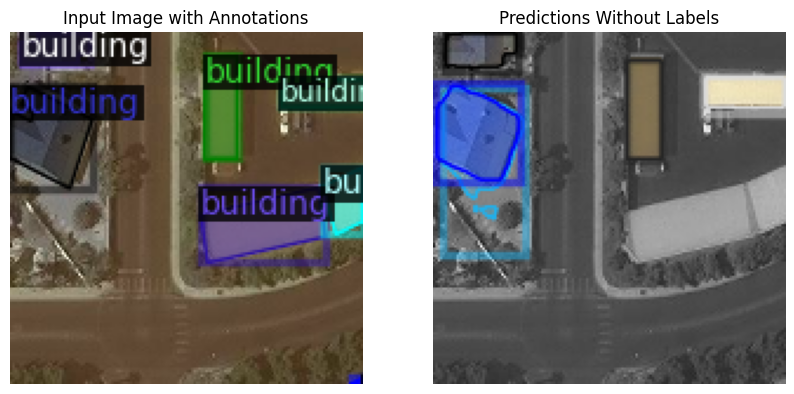

In [103]:
from detectron2.utils.visualizer import Visualizer, ColorMode

for d in random.sample(test_building, 3):
    im = cv2.imread(d["file_name"])
    print(d['file_name'])
    outputs = predictor(im)  # Get model predictions

    v1 = Visualizer(im[:, :, ::-1], metadata=test_building_metadata, scale=0.5)
    input_image = v1.draw_dataset_dict(d)
    
    instances = outputs["instances"].to("cpu")
    instances.remove("pred_classes")
    instances.remove("scores")

    v2 = Visualizer(im[:, :, ::-1], metadata=test_building_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v2.draw_instance_predictions(instances)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(input_image.get_image()[:, :, ::-1])
    ax[0].axis("off")
    ax[0].set_title("Input Image with Annotations")

    ax[1].imshow(out.get_image()[:, :, ::-1])
    ax[1].axis("off")
    ax[1].set_title("Predictions Without Labels")

    plt.show()
